<a href="https://colab.research.google.com/github/YVLavanya/Parallel-SGD/blob/main/sgd_noisy_communication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
import math
import cmath
print("DONE")
import time

DONE


In [2]:
california_data=pd.DataFrame(fetch_california_housing().data,columns=fetch_california_housing().feature_names)
print(california_data)
Y=fetch_california_housing().target
X=fetch_california_housing().data
print(type(X),type(Y),X.shape)
print(X)
print(Y)
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)
print("X Shape: ",X.shape)
print("Y Shape: ",Y.shape)
print("X_Train Shape: ",x_train.shape,type(x_train))
print("X_Test Shape: ",x_test.shape)
print("Y_Train Shape: ",y_train.shape)
print("Y_Test Shape: ",y_test.shape) 
# standardizing data
scaler = preprocessing.StandardScaler().fit(x_train)
print(scaler)
x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)
## Adding the PRIZE Column in the data
train_data=pd.DataFrame(x_train)
train_data['price']=y_train
print(train_data.shape)
print(type(train_data))

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  
0        -122.23  
1

In [3]:
def MyCustomSGD(train_data,learning_rate,n_iter,k,divideby,M,M1,bits,decoding,snr):
    train_data_shuffled=train_data.sample(frac=1) #shuffling rows of training data
    v=0
    # Initially we will keep our W and B as 0 as per the Training Data
    w=np.zeros(shape=(1,train_data.shape[1]-1))
    b=0
    par_vec_dequantised=np.zeros(shape=(k,train_data.shape[1]))#parameter vectors after decoding at clients
    w_pmtr=np.zeros(shape=(k,train_data.shape[1]-1))# weights w at clients
    b_pmtr=np.zeros(k)#parameter b at clients 

    qpsk_const=[1+1j,-1+1j,-1-1j,1-1j]
    bpsk_const=[1,-1]
    qam_const=[3+3j,1+3j,-3+3j,-1+3j,3+1j,1+1j,-3+1j,-1+1j,3-3j,1-3j,-3-3j,-1-3j,3-1j,1-1j,-3-1j,-1-1j]

    #constellation for digital modulation of gradients based on M value specified (uplink)
    if M==2:
       const=bpsk_const
    elif M==4:
       const=qpsk_const
    elif M==16:
       const=qam_const

    #constellation for digital modulation of updated parameters based on M1 value specified (downlink)
    if M1==2:
       downlink_const=bpsk_const
    elif M1==4:
       downlink_const=qpsk_const
    elif M1==16:
       downlink_const=qam_const

    cur_iter=1
    while(cur_iter<=n_iter): 
        # learning_rate=-(2.25*pow(10,-7)*cur_iter)+0.001225

        # We will create a small training data set of size K
        if v>=train_data.shape[0]:
          v=0;
        temp=train_data_shuffled.iloc[v:v+2] #select 2 rows from shuffled data
        v=v+2; #update v to select next two samples in next iteration

        # We create our X and Y from the above temp dataset
        y=np.array(temp['price'])
        x=np.array(temp.drop('price',axis=1))

        # We keep our initial gradients as 0
        w_gradient=np.zeros(shape=(1,train_data.shape[1]-1))
        b_gradient=0

        #intitialisations
        cur_grad=np.zeros(shape=(k,train_data.shape[1]))
        cur_grad_quantised=np.zeros(shape=(k,train_data.shape[1]))
        cur_grad_modulated=np.zeros(shape=(k,(int(math.ceil(train_data.shape[1]/math.log2(M))))),dtype=np.complex_)
        cur_grad_demodulated=np.zeros(shape=(k,train_data.shape[1]))
        cur_grad_dequantised=np.zeros(shape=(k,train_data.shape[1]))
        cur_grad_faded=np.zeros(shape=(k,int(math.ceil(train_data.shape[1]/math.log2(M)))),dtype=np.complex_)
        grad_decoded=np.zeros(shape=(k,int(math.ceil(train_data.shape[1]/math.log2(M)))),dtype=np.complex_)
        gradient_demod=np.zeros(shape=(k,train_data.shape[1]))
        grad=np.zeros(shape=(k,train_data.shape[1]))

        h=np.zeros(shape=(k,1),dtype=np.complex_)
        min_x=np.zeros(shape=(k,1),dtype=np.complex_)
        max_x=np.zeros(shape=(k,1),dtype=np.complex_)
        gradient=np.zeros((1,train_data.shape[1]),dtype=np.complex_)

        uptd_par_vec_received=np.zeros(shape=(k,int(math.ceil((train_data.shape[1]*bits)/math.log2(M1)))),dtype=np.complex_)
        par_vec_decoded=np.zeros(shape=(k,int(math.ceil(train_data.shape[1]*bits/math.log2(M1)))),dtype=np.complex_)
        par_vec_demod=np.zeros(shape=(k,train_data.shape[1]*bits))
        
        

        for i in range(k): # Calculating gradients 
            w_pmtr[i]=par_vec_dequantised[i][0:-1] #decoded weights at ith client
            b_pmtr[i]=par_vec_dequantised[i][-1]  #decoded bias at ith client
            prediction=np.dot(w_pmtr[i],x[i])+b_pmtr[i]
            cur_w_grad=(-2)*x[i]*(y[i]-(prediction))
            cur_b_grad=(-2)*(y[i]-(prediction))
            cur_grad[i]=np.append(cur_w_grad,cur_b_grad)   #gradient calculated at ith client 
            #print(cur_grad[i])
            cur_grad_quantised[i],min_x[i],max_x[i]=quantise_randomised(cur_grad[i])  #quantised gradient at ith client using randomised rounding
            pad_len=int((math.ceil(len(cur_grad_quantised[i])/math.log2(M)))*math.log2(M)-len(cur_grad_quantised[i]))

            # modulate gradients according to specified digital modulation scheme
            if M==2:
               cur_grad_modulated[i]=bpsk_modulate(cur_grad_quantised[i])    #gradient after modulation
            elif M==4:
               cur_grad_modulated[i]=qpsk(np.pad(cur_grad_quantised[i], (0,pad_len), mode='constant', constant_values=(0,0)))
            elif M==16:
               cur_grad_modulated[i]=qam(np.pad(cur_grad_quantised[i], (0,pad_len), mode='constant', constant_values=(0,0)))
            #generate complex fading coefficient at ith client
            p=np.random.normal(0,1/2)
            q=np.random.normal(0,1/2)
            h[i]=complex(p,q)          #fading coefficient each client
             
            cur_grad_faded[i]=h[i]*cur_grad_modulated[i]  #gradient multiplied with fading coefficient
            #print("cur_grad_faded=",cur_grad_faded)
            
        gradient= np.sum(cur_grad_faded, axis = 0) #sum of gradients affected by fading coefficients
        gradient_received=awgn(gradient,snr)  #received vector after noise addition      
        
        #decode transmitted symbols of client 1  and client 2 from the received vector 
        if(decoding==1):
         grad_decoded=decode_sic(gradient_received,h,const,M)#decoding gradients using SIC 
        elif(decoding==2):
         grad_decoded=joint_decoding(gradient_received,h,const,M)#decoding gradients using joint decoding
        else:
         grad_decoded=cur_grad_modulated #this case is for noiseless communication of gradients
        
        #demodulate the above symbols to get bits transmitted
        for j in range(k):
            if M==2:
              gradient_demod[j]=bpsk_demodulate(grad_decoded[j]) 
            elif M==4:
              gradient_demod[j]=(qpsk_demod(grad_decoded[j]))[0:train_data.shape[1]]
            elif M==16:
              gradient_demod[j]=(qam_demod(grad_decoded[j]))[0:train_data.shape[1]]
            grad[j]=decode_randomised(gradient_demod[j],min_x[j],max_x[j]) #dequantise the above vector
        
        final_gradient= np.sum(grad, axis = 0) #add the final dequantised gradients
        w_gradient=final_gradient[0:-1]
        b_gradient=final_gradient[-1]
      
        #Updating the weights(W) and Bias(b) with the above calculated Gradients
        w=w-learning_rate*(w_gradient/(k))
        b=b-learning_rate*(b_gradient/(k))
        updated_parameter_vector=np.append(w,b)


        #downlink transmission of updated parameter vector
        pmtr_encoded,min_pmtr,max_pmtr=encode_vector(updated_parameter_vector,bits)#quantise parameter vector and encode its elements using specified no of bits specified
    
        if M1==2:
               uptd_par_vec_tx=bpsk_modulate(pmtr_encoded)   #transmitted parameters after modulation 
        elif M1==4:
               uptd_par_vec_tx=qpsk(pmtr_encoded)
        elif M1==16:
               uptd_par_vec_tx=qam(pmtr_encoded)
        

        for i in range(k):
          uptd_par_vec_received[i]=awgn(uptd_par_vec_tx,snr) #received parameter vector ith client after noise addition
          par_vec_decoded[i]=decode_ML_detection(uptd_par_vec_received[i],downlink_const) #decoded parameter vector ith client
          
          if M1==2:
               par_vec_demod[i]=bpsk_demodulate(par_vec_decoded[i])   #parameter vector after demodulation ith client
          elif M1==4:
               par_vec_demod[i]=(qpsk_demod(par_vec_decoded[i]))
          elif M1==16:
               par_vec_demod[i]=(qam_demod(par_vec_decoded[i]))
          par_vec_dequantised[i]=decode_vector(par_vec_demod[i],min_pmtr,max_pmtr,bits) #dequantised vector ith client used for next epoch
        
        # Incrementing the iteration value
        cur_iter=cur_iter+1
        
        if cur_iter==3000:
          learning_rate=learning_rate/10
       
    return w,b #Returning the weights and Bias2

In [4]:
def MyCustomSGD_noiseless(train_data,learning_rate,n_iter,k,divideby,quantisation):
    w=np.zeros((1,train_data.shape[1]-1))
    b=0
    
    cur_iter=1
    while(cur_iter<=n_iter): 

        # We will create a small training data set of size K
        temp=train_data.sample(k)
        # We create our X and Y from the above temp dataset
        y=np.array(temp['price'])
        x=np.array(temp.drop('price',axis=1))
        #print(x[0].shape)
        
        # We keep our initial gradients as 0
        w_gradient=np.zeros(shape=(1,train_data.shape[1]-1))
        b_gradient=0
        
        for i in range(k): # Calculating gradients for point in our K sized dataset
            prediction=np.dot(w,x[i])+b
            cur_w_grad=(-2)*x[i]*(y[i]-(prediction)) #actual gradients w.r.t w
            cur_b_grad=(-2)*(y[i]-(prediction))   #actual gradient w.r.t b
            cur_grad=np.concatenate((cur_w_grad,cur_b_grad)) 
            cur_quant_grad,min_x,max_x=quantise_randomised(cur_grad)
            grad=decode_randomised(cur_quant_grad,min_x,max_x) #dequantise the above vector

            cur_w_grad_quantised=grad[:-1]
            cur_b_grad_quantised=grad[-1]
            if quantisation==1:
             w_gradient=w_gradient+(cur_w_grad_quantised)   # using quantised gradients while aggregating
             b_gradient=b_gradient+(cur_b_grad_quantised)
            else:
             w_gradient=w_gradient+(cur_w_grad)   # using quantised gradients while aggregating
             b_gradient=b_gradient+(cur_b_grad)
        w=w-learning_rate*(w_gradient/k)
        b=b-learning_rate*(b_gradient/k)
        cur_iter=cur_iter+1
        if cur_iter==3000:
          learning_rate=learning_rate/10

    
    return w,b 

In [5]:
#function for  ML detection of vector based on constellation 
def decode_ML_detection(x,const):
  y=np.zeros(len(x),dtype=np.complex_)
  for i in range(len(x)):
    p=ML_detect(x[i],const)
    y[i]=const[p]
  return y

In [6]:
#decoding using SIC,takes a vcetor and returns decoded vectors at 2 clients
def decode_sic(X,h,const,M):
  grad_decoded=np.zeros(shape=(2,int(math.ceil(train_data.shape[1]/(math.log2(M))))),dtype=np.complex_)
  const_1=h[0]*const
  const_2=h[1]*const
  y=np.zeros(shape=X.shape,dtype=np.complex_)
  z=np.zeros(shape=X.shape,dtype=np.complex_)
  if(abs(h[0])>abs(h[1])):
     for i in range(len(X)):
        y[i]=const[ML_detect(X[i],const_1)]
        z[i]=const[ML_detect((X[i]-(h[0]*y[i])),const_2)]
     return y,z
  else:
     for i in range(len(X)):
           z[i]=const[ML_detect(X[i],const_2)]
           y[i]=const[ML_detect((X[i]-(h[1]*y[i])),const_1)]
  grad_decoded[0]=y
  grad_decoded[1]=z
  return grad_decoded
  


In [7]:
#decoding using joint decoding,takes a vcetor and returns decoded vectors at 2 clients
def joint_decoding(X,h,const,M):
  grad_joint_decoded=np.zeros(shape=(2,int(math.ceil(train_data.shape[1]/(math.log2(M))))),dtype=np.complex_)
  dist=np.zeros(shape=(len(const),len(const)))
  const_1=h[0]*const
  const_2=h[1]*const
  v=np.zeros(shape=X.shape,dtype=np.complex_)
  w=np.zeros(shape=X.shape,dtype=np.complex_)
  for i in range(len(X)):
       distance=np.zeros(shape=(len(const),len(const)),dtype=np.complex_)
       for j in range(len(const)):
         for k in range(len(const)):
          dist[j][k]=(X[i]-(const_1[j]+const_2[k]))*(np.conj(X[i]-(const_1[j]+const_2[k])))
          #print(dist[j][k])
       #print(dist)
       min_dist=np.min(np.min(dist))
       #print(min_dist)
       indices= np.where(dist==min_dist)
       row_index, col_index = indices[0][0], indices[1][0]

       v[i]=const[row_index]
       w[i]=const[col_index]
  grad_joint_decoded[0]=v
  grad_joint_decoded[1]=w
  return grad_joint_decoded


In [8]:
def ML_detect(x,const):
   distance=np.zeros(len(const),dtype=np.complex_)
   for i in range(len(const)):
      distance[i]=(x-const[i])*np.conj(x-const[i])
   min_dist=np.min(distance)
   distance=np.array(distance)
   ind=np.where(distance==min_dist)[0][0]
   return ind

In [9]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

In [10]:
def bpsk_modulate(X):
  x=np.zeros(len(X))
  for i in range(len(X)):
    x[i]=2*X[i]-1;
  return x

In [11]:
def bpsk_demodulate(x):
  X=np.zeros(len(x))
  for i in range(len(x)):
    X[i]=(x[i]+1)/2;
  return X

In [12]:
def qpsk(X):
  Y=np.zeros(math.ceil(len(X)/2),dtype=np.complex_)
  l=0;
  for i in range(0,len(X),2):
     if(X[i]==0 and X[i+1]==0):
       Y[l]=(1+1j);
       l=l+1;
     elif (X[i]==0 and X[i+1]==1):
       Y[l]=(-1+1j);
       l=l+1;
     elif(X[i]==1 and X[i+1]==1):
       Y[l]=(-1-1j);
       l=l+1;
     elif(X[i]==1 and X[i+1]==0):
       Y[l]=(1-1j);
       l=l+1
  return Y
  

In [13]:
def qam(X):
  #print(X)
  qam_const=[3+3j,1+3j,-3+3j,-1+3j,3+1j,1+1j,-3+1j,-1+1j,3-3j,1-3j,-3-3j,-1-3j,3-1j,1-1j,-3-1j,-1-1j]
  Y=np.zeros(math.ceil(len(X)/4),dtype=np.complex_)
  l=0;
  for i in range(0,len(X),4):
     if(X[i]==0 and X[i+1]==0 and X[i+2]==0 and X[i+3]==0):
       Y[l]=qam_const[0];
       l=l+1;
     elif (X[i]==0 and X[i+1]==0 and X[i+2]==0 and X[i+3]==1):
       Y[l]=qam_const[1];
       l=l+1;
     elif(X[i]==0 and X[i+1]==0 and X[i+2]==1 and X[i+3]==0):
       Y[l]=qam_const[2]
       l=l+1;
     elif(X[i]==0 and X[i+1]==0 and X[i+2]==1 and X[i+3]==1):
       Y[l]=qam_const[3]
       l=l+1
     elif(X[i]==0 and X[i+1]==1 and X[i+2]==0 and X[i+3]==0):
       Y[l]=qam_const[4]
       l=l+1
     elif(X[i]==0 and X[i+1]==1 and X[i+2]==0 and X[i+3]==1):
       Y[l]=qam_const[5]
       l=l+1
     elif(X[i]==0 and X[i+1]==1 and X[i+2]==1 and X[i+3]==0):
       Y[l]=qam_const[6]
       l=l+1
     elif (X[i]==0 and X[i+1]==1 and X[i+2]==1 and X[i+3]==1):
       Y[l]=qam_const[7]
       l=l+1;
     elif(X[i]==1 and X[i+1]==0 and X[i+2]==0 and X[i+3]==0):
       Y[l]=qam_const[8]
       l=l+1;
     elif(X[i]==1 and X[i+1]==0 and X[i+2]==0 and X[i+3]==1):
       Y[l]=qam_const[9]
       l=l+1
     elif(X[i]==1 and X[i+1]==0 and X[i+2]==1 and X[i+3]==0):
       Y[l]=qam_const[10]
       l=l+1
     elif(X[i]==1 and X[i+1]==0 and X[i+2]==1 and X[i+3]==1):
       Y[l]=qam_const[11]
       l=l+1
     elif(X[i]==1 and X[i+1]==1 and X[i+2]==0 and X[i+3]==0):
       Y[l]=qam_const[12]
       l=l+1
     elif(X[i]==1 and X[i+1]==1 and X[i+2]==0 and X[i+3]==1):
       Y[l]=qam_const[13]
       l=l+1
     elif(X[i]==1 and X[i+1]==1 and X[i+2]==1 and X[i+3]==0):
       Y[l]=qam_const[14];
       l=l+1
     elif(X[i]==1 and X[i+1]==1 and X[i+2]==1 and X[i+3]==1):
       Y[l]=qam_const[15];
       l=l+1
  return Y

In [14]:
def qpsk_demod(X):
  y=np.zeros(2*len(X))
  j=0;
  for i in range(len(X)):
      if(X[i]==1+1j):
        y[j]=0;
        y[j+1]=0;
        j=j+2;
      elif(X[i]==-1+1j):
        y[j]=0;
        y[j+1]=1;
        j=j+2;
      elif(X[i]==-1-1j):
        y[j]=1;
        y[j+1]=1;
        j=j+2;
      elif(X[i]==1-1j):
        y[j]=1;
        y[j+1]=0;
        j=j+2;
  return y
  

In [15]:
def qam_demod(X):
  qam_const=[3+3j,1+3j,-3+3j,-1+3j,3+1j,1+1j,-3+1j,-1+1j,3-3j,1-3j,-3-3j,-1-3j,3-1j,1-1j,-3-1j,-1-1j]
  y=np.zeros(4*len(X))
  j=0;
  for i in range(len(X)):
    for k in range(16):
      if(X[i]==qam_const[k]):
        g=bin(k).replace("0b", "")
        g=g.zfill(4)
        #print(g)
        y[j]=g[0];
        y[j+1]=g[1];
        y[j+2]=g[2];
        y[j+3]=g[3];
        j=j+4;
        break;
      
  return y

In [16]:
def encode_randomised(x):
    y=np.zeros(len(x))
    for i in range(len(x)):
        y[i]=np.random.binomial(n=1, p=x[i])
    return y

def decode_randomised(x,min_X,max_X):
      y=np.zeros(len(x))
      for i in range(len(x)):
           y[i]=x[i]
      Y=(y*(max_X-min_X))+min_X
      return Y

def quantise_randomised(X):
   min_X=min(X)
   max_X=max(X)
   X_shifted=X-min_X
   X_scaled=X_shifted/(max(X_shifted))
   #print(X_scaled)
   y=encode_randomised(X_scaled)
   return y,min_X,max_X

In [17]:
def decode_vector(x,min_x,max_x,no_bits):
  len_y=int(len(x)/no_bits)
  y=np.zeros(len_y)
  h=np.zeros(no_bits)
  interval=(max_x-min_x)/pow(2,no_bits)
  level=interval/2
  j=0;
  for i in range(len_y):
     for k in range(pow(2,no_bits)):
       r=(bin(k)[2:].zfill(no_bits))
       for l in range(no_bits):
         h[l]=r[l]
       if(((x[j:j+no_bits])==h).all()):
        y[i]=min_x+level+k*interval
        j=j+no_bits
        break
  return y

In [18]:
def encode_vector(x,no_bits):
  X=np.zeros(shape=(len(x),no_bits))
  min_x=min(x)
  max_x=max(x) 
  interval=(max_x-min_x)/pow(2,no_bits)
  for i in range(len(x)):
    for j in range(0,pow(2,no_bits)):
     p=min_x+(j*interval)
     q=min_x+((j+1)*interval)
     if x[i]==max_x:
        g=bin((pow(2,no_bits)-1)).replace("0b", "")
        g=g.zfill(no_bits)
     if p<=x[i]<q:
        g=bin(j).replace("0b", "")
        g=g.zfill(no_bits)
        break
    for k in range(no_bits):
      X[i,k]=g[k]
  Y=np.reshape(X,len(x)*no_bits)
  return Y,min_x,max_x

In [19]:
def predict(x,w,b):
 y_pred=[]
 for i in range(len(x)):
  y=np.asscalar(np.dot(w,x[i])+b)
  y_pred.append(y)
 return np.array(y_pred)

In [20]:
MSE_qpsk_SIC_bpsk=np.zeros(10)
MSE_qpsk_SIC_qpsk=np.zeros(10)
MSE_qpsk_SIC_qam=np.zeros(10)
MSE_qpsk_joint_decoding_bpsk=np.zeros(10)
MSE_qpsk_joint_decoding_qam=np.zeros(10)
MSE_qpsk_joint_decoding_qpsk=np.zeros(10)

MSE_bpsk_SIC_bpsk=np.zeros(10)
MSE_bpsk_SIC_qpsk=np.zeros(10)
MSE_bpsk_SIC_qam=np.zeros(10)
MSE_bpsk_joint_decoding_bpsk=np.zeros(10)
MSE_bpsk_joint_decoding_qam=np.zeros(10)
MSE_bpsk_joint_decoding_qpsk=np.zeros(10)

MSE_qam_SIC_bpsk=np.zeros(10)
MSE_qam_SIC_qpsk=np.zeros(10)
MSE_qam_SIC_qam=np.zeros(10)
MSE_qam_joint_decoding_bpsk=np.zeros(10)
MSE_qam_joint_decoding_qam=np.zeros(10)
MSE_qam_joint_decoding_qpsk=np.zeros(10)

MSE_quantized_gradients=np.zeros(10)
MSE_full_precision=np.zeros(10)

In [21]:
#M and M1 denote number of symbols in digital modulation in uplink and downlink respectively
#decoding=1 for SIC and decoding=2 for joint decoding
#'bits' is the number of bits used to encode each component of updated parameter vector after uniform quantisation 
def function_SGD(s,epochs):
  if s=="bpsk_SIC_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=2,M1=2,bits=4,decoding=1,snr=20)
  elif s=="qpsk_SIC_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=4,M1=2,bits=4,decoding=1,snr=20)
  elif s=="qam_SIC_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=16,M1=2,bits=4,decoding=1,snr=20)
  elif s=="bpsk_JD_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=2,M1=2,bits=4,decoding=2,snr=20)
  elif s=="qpsk_JD_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=4,M1=2,bits=4,decoding=2,snr=20)
  elif s=="qam_JD_bpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=16,M1=2,bits=4,decoding=2,snr=20)
  elif s=="qantised_SGD":
    w,b=MyCustomSGD_noiseless(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,quantisation=1)
  elif s=="full_precision_SGD":
    w,b=MyCustomSGD_noiseless(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,quantisation=0)
  elif s=="bpsk_SIC_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=2,M1=4,bits=4,decoding=1,snr=20)
  elif s=="qpsk_SIC_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=4,M1=4,bits=4,decoding=1,snr=20)
  elif s=="qam_SIC_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=16,M1=4,bits=4,decoding=1,snr=20)
  elif s=="bpsk_JD_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=2,M1=4,bits=4,decoding=2,snr=20)
  elif s=="qpsk_JD_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=4,M1=4,bits=4,decoding=2,snr=20)
  elif s=="qam_JD_qpsk":
    w,b=MyCustomSGD(train_data,learning_rate=0.001,n_iter=epochs,divideby=1,k=2,M=16,M1=4,bits=4,decoding=2,snr=20)
  return w,b


In [22]:
#'bpsk_SIC_bpsk' indicates gradients are modulated using bpsk,decoded using SIC and bpsk is used to modulate updated parameters 
pmtr_list=["bpsk_SIC_bpsk","qpsk_SIC_bpsk","qam_SIC_bpsk","bpsk_JD_bpsk","qpsk_JD_bpsk","qam_JD_bpsk","qantised_SGD","full_precision_SGD","bpsk_SIC_qpsk","qpsk_SIC_qpsk","qam_SIC_qpsk","bpsk_JD_qpsk","qpsk_JD_qpsk","qam_JD_qpsk"]
MSE=np.zeros(shape=(len(pmtr_list),10))

In [23]:

print(MSE)
mse_training=np.zeros(10)
epoch=np.zeros(10)
for j in pmtr_list[0:14]: 
 print(j)
 epochs=500
 for i in range(10):
    w,b=function_SGD(j,epochs)
    print(w,b)
    y_pred_customsgd=predict(x_test,w,b)
    y_pred_customsgd_training=predict(x_train,w,b)
    MSE[pmtr_list.index(j)][i]=mean_squared_error(y_test, y_pred_customsgd)
    #mse_training[i]=mean_squared_error(y_train, y_pred_customsgd_training)
    epoch[i]=epochs
    epochs=epochs+500
    print('Mean Squared Error :',mean_squared_error(y_test, y_pred_customsgd))
    print('training error:',mean_squared_error(y_train, y_pred_customsgd_training))
 print(MSE)
 #print(mse_training)
 print(epoch)
MSE_bpsk_SIC_bpsk=MSE[0]
MSE_qpsk_SIC_bpsk=MSE[1]
MSE_qam_SIC_bpsk=MSE[2]
MSE_bpsk_joint_decoding_bpsk=MSE[3]
MSE_qpsk_joint_decoding_bpsk=MSE[4]
MSE_qam_joint_decoding_bpsk=MSE[5]
MSE_quantized_gradients=MSE[6]
MSE_full_precision=MSE[7]
MSE_bpsk_SIC_qpsk=MSE[8]
MSE_qpsk_SIC_qpsk=MSE[9]
MSE_qam_SIC_qpsk=MSE[10]
MSE_bpsk_joint_decoding_qpsk=MSE[11]
MSE_qpsk_joint_decoding_qpsk=MSE[12]
MSE_qam_joint_decoding_qpsk=MSE[13]
 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
bpsk_SIC_bpsk
[[ 0.58244435  0.15473426  0.04566808 -0.04357353  0.0400117  -0.91410569
  -0.10573868  0.02240893]] 1.2232683592646234
Mean Squared Error : 1.3405320844806354
training error: 2.1967010227633796
[[ 0.57986018  0.21767352  0.16559608 -0.11067424  0.05482863 -0.09345461
  -0.18120447 -0.0886495 ]] 1.7345449407961713
Mean Squared Error : 0.7513204837772215
training error: 0.8020878799175326
[[ 0.73852009  0.32256635  0.00574322  0.05400594  0.08573483 -3.1187887
  -0.17150641 -0.06635245]] 2.042649772696992
Mean Squared

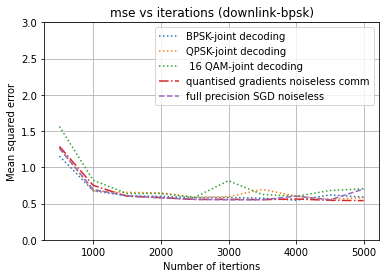

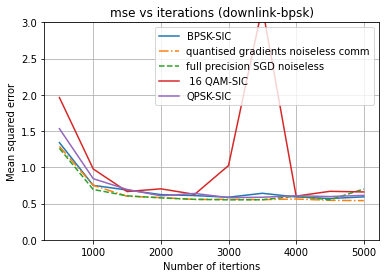

In [24]:
plt.plot(epoch,MSE_bpsk_joint_decoding_bpsk, label= 'BPSK-joint decoding',linestyle=":")
plt.plot(epoch,MSE_qpsk_joint_decoding_bpsk, label= 'QPSK-joint decoding',linestyle=":")
plt.plot(epoch,MSE_qam_joint_decoding_bpsk, label= ' 16 QAM-joint decoding',linestyle=":")
plt.plot(epoch,MSE_quantized_gradients, label= 'quantised gradients noiseless comm',linestyle="-.")
plt.plot(epoch,MSE_full_precision, label= 'full precision SGD noiseless',linestyle="--")
plt.xlabel('Number of itertions')
plt.ylabel('Mean squared error')
plt.grid()
plt.ylim([0,3])
plt.title('mse vs iterations (downlink-bpsk)')
plt.legend()
plt.show()
plt.plot(epoch,MSE_bpsk_SIC_bpsk, label= 'BPSK-SIC')
plt.plot(epoch,MSE_quantized_gradients, label= 'quantised gradients noiseless comm',linestyle="-.")
plt.plot(epoch,MSE_full_precision, label= 'full precision SGD noiseless',linestyle="--")
plt.plot(epoch,MSE_qam_SIC_bpsk, label= ' 16 QAM-SIC')
plt.plot(epoch,MSE_qpsk_SIC_bpsk, label= 'QPSK-SIC')
plt.xlabel('Number of itertions')
plt.ylabel('Mean squared error')
plt.ylim([0,3])
plt.grid()
plt.title('mse vs iterations (downlink-bpsk)')
plt.legend()
plt.show()


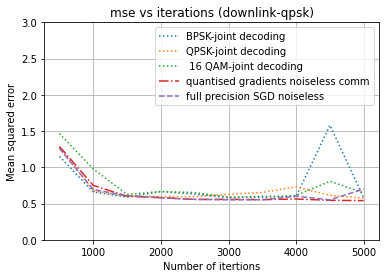

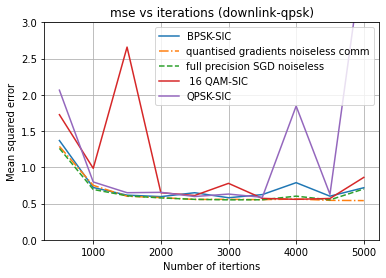

In [25]:
plt.plot(epoch,MSE_bpsk_joint_decoding_qpsk, label= 'BPSK-joint decoding',linestyle=":")
plt.plot(epoch,MSE_qpsk_joint_decoding_qpsk, label= 'QPSK-joint decoding',linestyle=":")
plt.plot(epoch,MSE_qam_joint_decoding_qpsk, label= ' 16 QAM-joint decoding',linestyle=":")
plt.plot(epoch,MSE_quantized_gradients, label= 'quantised gradients noiseless comm',linestyle="-.")
plt.plot(epoch,MSE_full_precision, label= 'full precision SGD noiseless',linestyle="--")
plt.xlabel('Number of itertions')
plt.ylabel('Mean squared error')
plt.grid()
plt.ylim([0,3])
plt.title('mse vs iterations (downlink-qpsk)')
plt.legend()
plt.show()
plt.plot(epoch,MSE_bpsk_SIC_qpsk, label= 'BPSK-SIC')
plt.plot(epoch,MSE_quantized_gradients, label= 'quantised gradients noiseless comm',linestyle="-.")
plt.plot(epoch,MSE_full_precision, label= 'full precision SGD noiseless',linestyle="--")
plt.plot(epoch,MSE_qam_SIC_qpsk, label= ' 16 QAM-SIC')
plt.plot(epoch,MSE_qpsk_SIC_qpsk, label= 'QPSK-SIC')
plt.xlabel('Number of itertions')
plt.ylabel('Mean squared error')
plt.ylim([0,3])
plt.grid()
plt.title('mse vs iterations (downlink-qpsk)')
plt.legend()
plt.show()
#labels indicate type of modulation to modulate gradients followed by decoding technique used
